<a href="https://colab.research.google.com/github/rakibulhaque9954/fer2013_dataset_vit_model/blob/main/FER2013_Emotion_model_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libararies and Installations

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import InputLayer, Conv2D, BatchNormalization, Flatten, Dense, MaxPool2D, Dropout, Rescaling, RandomRotation, RandomFlip, RandomContrast
from keras.regularizers import L2
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
import tensorflow_probability as tfp
from keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2

## Logging in to Wandb

### Wandb Installation

In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=c68d12018b54a737d4a47073e13ea9ed975b1ffd08e56ccf683051eceaa0fd26
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [3]:
import wandb
from wandb.keras import WandbCallback

In [4]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
wandb.init(project = 'Emotion_detection_FER2013', entity = 'rakibulhaque9954')

wandb: Currently logged in as: rakibulhaque9954. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230916_022702-154bamjw
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run peach-morning-3
wandb: ⭐️ View project at https://wandb.ai/rakibulhaque9954/Emotion_detection_FER2013
wandb: 🚀 View run at https://wandb.ai/rakibulhaque9954/Emotion_detection_FER2013/runs/154bamjw


In [8]:
wandb.config =  {
    'BATCH_SIZE' : 32,
    'IM_SIZE': 224,
    'LEARNING_RATE': 0.001,
    'N_EPOCHS': 20,
    'DROPOUT_RATE': 0.0,
    'REGULARIZATION_RATE': 0.0,
    'N_FILTERS': 6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE': 2,
    'N_DENSE_1': 100,
    'N_DENSE_2': 10,
    'NUM_CLASSES': 5,
    'PATCH_SIZE': 16,
    'CLASS_NAMES': ['anger', 'happy', 'sad', 'surprise', 'neutral']

}

In [9]:
CONFIGURATION = wandb.config

# FER2013 Dataset loading from Kaggle

In [10]:
!pip3 install kaggle





In [11]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [12]:
# giving user raed and write rights in kaggle file
!chmod 600 ~/.kaggle/kaggle.json


In [13]:
# copying api command of dataset from kaggle.json and downloading fer2013
!kaggle datasets download -d deadskull7/fer2013

 98% 95.0M/96.6M [00:05<00:00, 22.6MB/s]
100% 96.6M/96.6M [00:05<00:00, 17.0MB/s]


In [14]:
!unzip '/content/fer2013.zip' -d '/content/dataset'

Archive:  /content/fer2013.zip
  inflating: /content/dataset/fer2013.csv  


# Reading CSV and Unraveling pics from .csv format


## Splitting to different dataset and converting to images

In [53]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

# Load the CSV dataset
data = pd.read_csv("dataset/fer2013.csv")  # Replace with the path to your CSV file

# Create directories for dataset organization
dataset_dir = "datasets"
os.makedirs(dataset_dir, exist_ok=True)

classes = data['emotion'].unique()
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

for c in classes:
    os.makedirs(os.path.join(train_dir, str(c)), exist_ok=True)
    os.makedirs(os.path.join(val_dir, str(c)), exist_ok=True)
    os.makedirs(os.path.join(test_dir, str(c)), exist_ok=True)

# Split data and save images to directories
for c in classes:
    class_data = data[data['emotion'] == c]
    train_data, test_data = train_test_split(class_data, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

    for index, row in train_data.iterrows():
        # Save the image to the training directory
        image_data = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
        file_name = f"{index}.png"
        file_path = os.path.join(train_dir, str(c), file_name)
        Image.fromarray(image_data).save(file_path)

    for index, row in val_data.iterrows():
        # Save the image to the validation directory
        image_data = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
        file_name = f"{index}.png"
        file_path = os.path.join(val_dir, str(c), file_name)
        Image.fromarray(image_data).save(file_path)

    for index, row in test_data.iterrows():
        # Save the image to the test directory
        image_data = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
        file_name = f"{index}.png"
        file_path = os.path.join(test_dir, str(c), file_name)
        Image.fromarray(image_data).save(file_path)


# Extracting from CSV and converting to image dataset

## Splitting to different dataset, converting to dataset and Resizing
<p> To improve consistency and fit the model </p>


In [13]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

# Load the CSV dataset
data = pd.read_csv("dataset/fer2013.csv")  # Replace with the path to your CSV file

# Create directories for dataset organization
dataset_dir = "datasetss"
os.makedirs(dataset_dir, exist_ok=True)

classes = data['emotion'].unique()
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

for c in classes:
    os.makedirs(os.path.join(train_dir, str(c)), exist_ok=True)
    os.makedirs(os.path.join(val_dir, str(c)), exist_ok=True)
    os.makedirs(os.path.join(test_dir, str(c)), exist_ok=True)

# Resize, split data, and save images to directories
for c in classes:
    class_data = data[data['emotion'] == c]
    train_data, test_data = train_test_split(class_data, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

    for index, row in train_data.iterrows():
        # Resize the image to 224x224 and save to the training directory
        image_data = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
        resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
        file_name = f"{index}.png"
        file_path = os.path.join(train_dir, str(c), file_name)
        resized_image.save(file_path)

    for index, row in val_data.iterrows():
        # Resize the image to 224x224 and save to the validation directory
        image_data = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
        resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
        file_name = f"{index}.png"
        file_path = os.path.join(val_dir, str(c), file_name)
        resized_image.save(file_path)

    for index, row in test_data.iterrows():
        # Resize the image to 224x224 and save to the test directory
        image_data = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
        resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
        file_name = f"{index}.png"
        file_path = os.path.join(test_dir, str(c), file_name)
        resized_image.save(file_path)


<ipython-input-13-7ee77c162920>:33: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
<ipython-input-13-7ee77c162920>:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
<ipython-input-13-7ee77c162920>:49: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)


## Extracting without Few Classes

In [73]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

# Load the CSV dataset
data = pd.read_csv("dataset/fer2013.csv")  # Replace with the path to your CSV file

# Create directories for dataset organization
dataset_dir = "datasets"
os.makedirs(dataset_dir, exist_ok=True)

# Define class names
class_names = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}

# Map original class labels to new class labels
data['emotion'] = data['emotion'].map(class_names)

# Extract unique class names
classes = data['emotion'].unique()
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

for c in classes:
    if c not in ["fear", "disgust"]:  # Exclude "fear" and "disgust" classes
        os.makedirs(os.path.join(train_dir, c), exist_ok=True)
        os.makedirs(os.path.join(val_dir, c), exist_ok=True)
        os.makedirs(os.path.join(test_dir, c), exist_ok=True)

# Resize, split data, and save images to directories
for c in classes:
    if c not in ["fear", "disgust"]:  # Exclude "fear" and "disgust" classes
        class_data = data[data['emotion'] == c]
        train_data, test_data = train_test_split(class_data, test_size=0.2, random_state=42)
        val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

        for index, row in train_data.iterrows():
            # Resize the image to 224x224 and save to the training directory
            image_data = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
            resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
            file_name = f"{index}.png"
            file_path = os.path.join(train_dir, c, file_name)  # Use class names
            resized_image.save(file_path)

        for index, row in val_data.iterrows():
            # Resize the image to 224x224 and save to the validation directory
            image_data = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
            resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
            file_name = f"{index}.png"
            file_path = os.path.join(val_dir, c, file_name)  # Use class names
            resized_image.save(file_path)

        for index, row in test_data.iterrows():
            # Resize the image to 224x224 and save to the test directory
            image_data = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
            resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
            file_name = f"{index}.png"
            file_path = os.path.join(test_dir, c, file_name)  # Use class names
            resized_image.save(file_path)


<ipython-input-73-482f9c1511b9>:50: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
<ipython-input-73-482f9c1511b9>:58: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
<ipython-input-73-482f9c1511b9>:66: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)


In [72]:
CLASS_NAMES = ['Angry', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Limiting to only 10000 samples

In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

# Load the CSV dataset
data = pd.read_csv("dataset/fer2013.csv")  # Replace with the path to your CSV file

# Create directories for dataset organization
dataset_dir = "datasets"
os.makedirs(dataset_dir, exist_ok=True)

# Define class names
class_names = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}

# Map original class labels to new class labels
data['emotion'] = data['emotion'].map(class_names)

# Exclude "fear" and "disgust" classes
data = data[data['emotion'].isin(["anger", "happy", "sad", "surprise", "neutral"])]

# Extract unique class names
classes = data['emotion'].unique()
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")

# Limit the training dataset to 10,000 samples
data = data.sample(n=10000, random_state=42)

for c in classes:
    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(val_dir, c), exist_ok=True)

# Resize, split data, and save images to directories
for c in classes:
    class_data = data[data['emotion'] == c]
    train_data, val_data = train_test_split(class_data, test_size=0.1, random_state=42)

    for index, row in train_data.iterrows():
        # Resize the image to 224x224 and save to the training directory
        image_data = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
        resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
        file_name = f"{index}.png"
        file_path = os.path.join(train_dir, c, file_name)  # Use class names
        resized_image.save(file_path)

    for index, row in val_data.iterrows():
        # Resize the image to 224x224 and save to the validation directory
        image_data = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
        resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
        file_name = f"{index}.png"
        file_path = os.path.join(val_dir, c, file_name)  # Use class names
        resized_image.save(file_path)


<ipython-input-15-03a1d2ff6c5e>:51: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)
<ipython-input-15-03a1d2ff6c5e>:59: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = Image.fromarray(image_data).resize((224, 224), Image.ANTIALIAS)


# Data Preprocessing

In [16]:
train_directory = '/content/datasets/train'
# using test dataset as val dataset
validation_directory = '/content/datasets/val'


In [17]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode= 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    seed = 99,
    shuffle = True

)

Found 8997 files belonging to 5 classes.


In [18]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names =  CONFIGURATION['CLASS_NAMES'],
    color_mode= 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    seed = 99,
    shuffle = True

)

Found 1003 files belonging to 5 classes.


In [19]:
for i in val_dataset.take(1):
  # visualizing labels and their respective values
  print(i) # binary vectors or int class depending on the mode

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[ 54.,  54.,  54.],
         [ 54.,  54.,  54.],
         [ 54.,  54.,  54.],
         ...,
         [ 21.,  21.,  21.],
         [ 21.,  21.,  21.],
         [ 21.,  21.,  21.]],

        [[ 54.,  54.,  54.],
         [ 54.,  54.,  54.],
         [ 54.,  54.,  54.],
         ...,
         [ 21.,  21.,  21.],
         [ 21.,  21.,  21.],
         [ 21.,  21.,  21.]],

        [[ 54.,  54.,  54.],
         [ 54.,  54.,  54.],
         [ 54.,  54.,  54.],
         ...,
         [ 21.,  21.,  21.],
         [ 21.,  21.,  21.],
         [ 21.,  21.,  21.]],

        ...,

        [[ 96.,  96.,  96.],
         [ 96.,  96.,  96.],
         [ 96.,  96.,  96.],
         ...,
         [199., 199., 199.],
         [198., 198., 198.],
         [198., 198., 198.]],

        [[ 97.,  97.,  97.],
         [ 97.,  97.,  97.],
         [ 97.,  97.,  97.],
         ...,
         [199., 199., 199.],
         [198., 198., 198.],
       

# Dataset Visualization

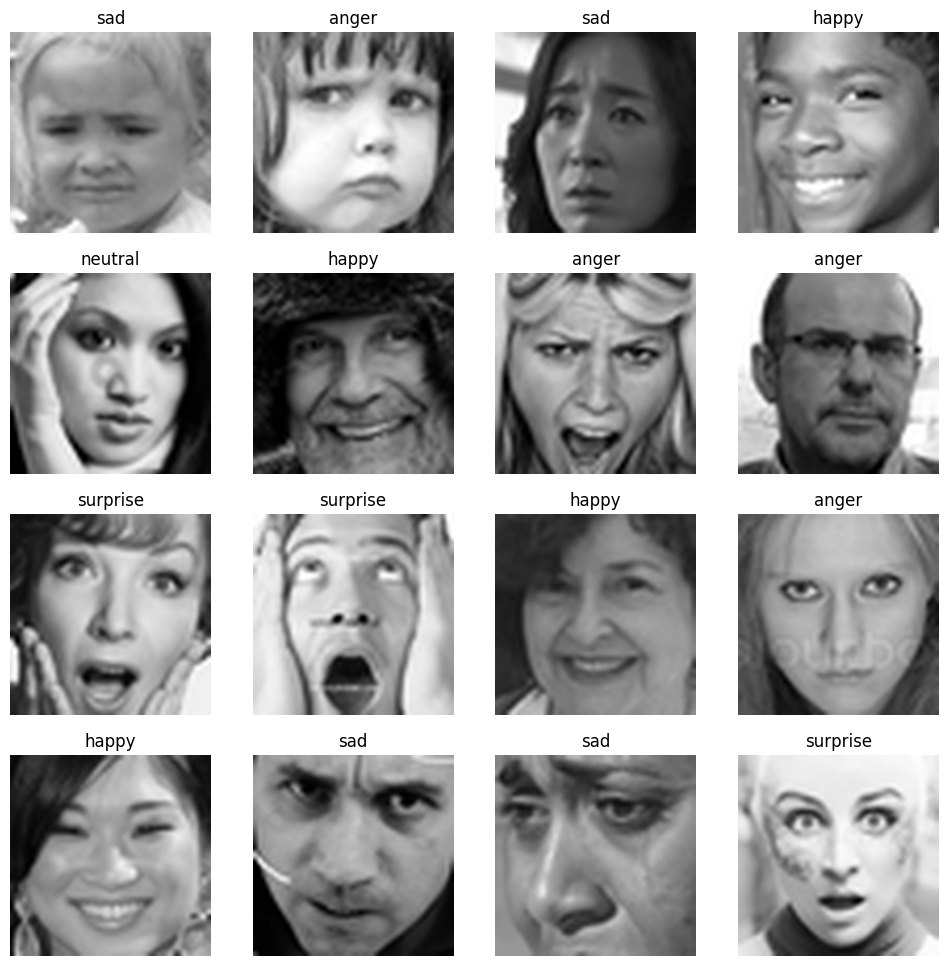

In [21]:
plt.figure(figsize = (12, 12))
for images, labels in train_dataset.take(1): #taking 1 batch of images
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.0) # normalization
    label_index = tf.argmax(labels[i]).numpy()
    plt.title(CONFIGURATION['CLASS_NAMES'][label_index])
    # plt.title((tf.argmax(labels[i])).numpy()) printing when printing the index value of classes when using binary vector mode
    ax.axis('off')

# Data Augmentation



In [22]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor= (-0.025, 0.025)), # rotation is limited
    RandomFlip(mode= 'horizontal'),
    RandomContrast(factor= 0.1)

])

In [23]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

# Dataset Preparation

In [24]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [25]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [26]:
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    tf.keras.layers.Rescaling(1./255)
]) # its good for deployment and prevents extra steps

<hr>
<h1>Modeling</h1>
<hr>

#Hugging Face Transformers


## Installation

In [27]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00


## Pretrained ViT Model(google/vit)

In [36]:
from keras.layers import Permute
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1./255),
    # Changing the shape of each image by permuting for ex: (1, 224, 224, 3) -> (1, 3, 224, 224)
    # This is to match the shape of the hugging face pretrained model, just reconfiguring the order not the values itself
    # default is (Batch, Height, Width, Channels) but permute just reconfigures the order
    # After Permute -> (Batch, Channels, Height, Width)(using indexes of shape)
    Permute((3, 1, 2))
])

In [37]:
from transformers import TFViTModel
from keras.layers import Input


hf_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
hf_model.trainable = False
 # this is important otherwise there is gradients computation error as it can lead to weights being updated during back propogation

inputs = Input(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)) # shape is different as set by different models
x = resize_rescale_layers(inputs) # reconfiguring the order of the shape
x = hf_model.vit(x)[0][:, 0, :] # output preference and shape

# classifier
output = Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax')(x)
# ft is for fine-tuned
ft_hf_model = tf.keras.Model(inputs = inputs, outputs = output)
ft_hf_model.summary()

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem_2  (None, 768)               0   

In [29]:
# from keras.models import load_model
# from keras.layers import Input
# hf_model = load_model('/content/drive/MyDrive/Colab Notebooks/Hugging_face_model/finetuned_vit_model')
# hf_model.trainable = False # this is important otehrwise there is gradients computation error as it can lead to weights being updated during back propogation

# inputs = Input(shape = (256, 256, 3)) # shape is different as set by different models
# x = hf_model(inputs) # reconfiguring the order of the shape


# # classifier
# x = Dropout(0.5)(x)
# output = x

# # ft is for fine-tuned
# ft_hf_model = tf.keras.Model(inputs = inputs, outputs = output)

# Drive Login

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Learning Rate Schedular

In [ ]:
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
schedular_callback = LearningRateScheduler(scheduler, verbose=1)

# Callbacks

## Checkpoint Callback()

In [30]:
from keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Hugging_face_model/fer2013_vit_modelv3.1", save_best_only=True)

### Confusion Matrix CallBack()

In [ ]:

from keras.callbacks import Callback
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in validation_dataset:
      predicted.append(ft_hf_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])

    wandb.log({"conf_mat": cm})

### Log Results Table Callback()

In [ ]:
class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):
    columns = ['image', 'Predicted', 'Label']

    val_table = wandb.Table(columns = columns)  # validation table

    for im, label in validation_dataset.take(25):

      pred = CONFIGURATION['CLASS_NAMES'][tf.argmax(ft_hf_model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION['CLASS_NAMES'][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]

      val_table.add_data(*row)

    wandb.log({'Model Results': val_table})


# Compile and Fit Model

In [58]:
# from keras.models import load_model
# ft_hf_model = load_model('/content/drive/MyDrive/Colab Notebooks/Hugging_face_model/fer2013_vit_modelv2')


In [38]:
ft_hf_model.compile(
     optimizer = Adam(learning_rate = 1e-4), #learning rate needs to be lower when finetuning a model
                     loss = CategoricalCrossentropy(),
                     metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k = 2, name = 'top_k_accuracy')]
    )


In [40]:
history = ft_hf_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'] * 4,
    verbose = 1,
    callbacks = [checkpoint_callback, WandbCallback()]#, LogResultsTable(), LogConfMatrix()] # logging data to wandb
)

Epoch 1/80
282/282 [==============================] - 21s 74ms/step - loss: 0.9530 - accuracy: 0.6315 - top_k_accuracy: 0.8305 - val_loss: 0.9793 - val_accuracy: 0.6032 - val_top_k_accuracy: 0.8156
Epoch 2/80
282/282 [==============================] - 21s 73ms/step - loss: 0.9482 - accuracy: 0.6357 - top_k_accuracy: 0.8328 - val_loss: 0.9747 - val_accuracy: 0.6072 - val_top_k_accuracy: 0.8185
Epoch 3/80
282/282 [==============================] - 21s 73ms/step - loss: 0.9438 - accuracy: 0.6373 - top_k_accuracy: 0.8302 - val_loss: 0.9700 - val_accuracy: 0.6082 - val_top_k_accuracy: 0.8195
Epoch 4/80
282/282 [==============================] - 21s 73ms/step - loss: 0.9357 - accuracy: 0.6431 - top_k_accuracy: 0.8381 - val_loss: 0.9659 - val_accuracy: 0.6102 - val_top_k_accuracy: 0.8225
Epoch 5/80
282/282 [==============================] - 21s 73ms/step - loss: 0.9321 - accuracy: 0.6431 - top_k_accuracy: 0.8365 - val_loss: 0.9621 - val_accuracy: 0.6092 - val_top_k_accuracy: 0.8205
Epoch 6/80

KeyboardInterrupt: ignored

In [ ]:
ft_hf_model.evaluate(validation_dataset)

72/72 [==============================] - 35s 441ms/step - loss: 0.2860 - accuracy: 0.8955 - top_k_accuracy: 0.9754


[0.28598085045814514, 0.89552241563797, 0.9754170179367065]

# Saving the Model

Its good to save the model normally then convert to onyx format then to convert to .h5 and then convert it

In [ ]:
ft_hf_model.save('finetuned_vit')

#Testing hf Model

In [ ]:
# testing
test_image = '/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/103442.jpg_rotation_1.jpg'
test_image = cv2.imread(test_image)
test_image = cv2.resize(test_image, (256, 256))
print(test_image.shape)
test_image = tf.expand_dims(test_image, axis = 0)
print(test_image.shape)


(256, 256, 3)
(1, 256, 256, 3)


In [ ]:
ft_hf_model.evaluate(validation_dataset)

 6/72 [=>............................] - ETA: 28s - loss: 0.2486 - accuracy: 0.9010 - top_k_accuracy: 0.9792

KeyboardInterrupt: ignored

In [ ]:
CLASS_NAMES[np.argmax(ft_hf_model.predict(test_image))]

1/1 [==============================] - 0s 66ms/step


'angry'

# Evaluation

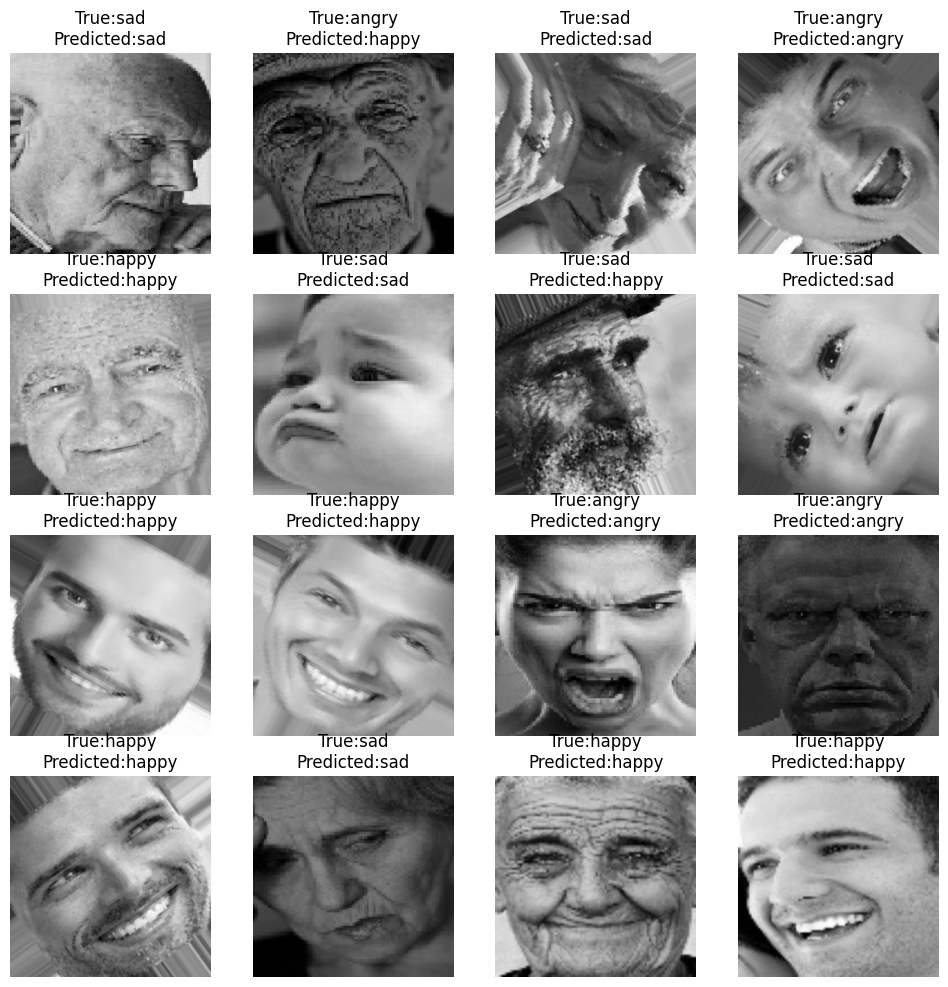

In [ ]:
plt.figure(figsize = (12, 12))
for images, labels in validation_dataset.take(1): #taking 1 batch of images
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.0) # normalization
    label_index = tf.argmax(labels[i]).numpy()
    predicted_index = tf.argmax(ft_hf_model(tf.expand_dims(images[i], axis = 0)).numpy()[0])
    plt.title('True:' + CLASS_NAMES[label_index] + '\n' + 'Predicted:' + CLASS_NAMES[predicted_index])
    ax.axis('off')

In [ ]:
15/16 # accuracy rate using ensembling

0.9375

# Testing

In [ ]:
test_image = cv2.imread('/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/110020.jpg_brightness_2.jpg')

test_image = cv2.resize(test_image, (256, 256))
# converting image to tensor
image = tf.constant(test_image, dtype = tf.float32)

# expanding dimensions or batching
image = tf.expand_dims(image, axis = 0) # axis = 0 means adding dimesion along the front for instance: (224, 224, 3) -> (0, 224, 224, 3) batched tensor

print(CLASS_NAMES[tf.argmax(ensemble_model(image), axis = -1).numpy()[0]]) # printing alongwith class since our dataset was preset with vector mode

happy


# Confusion matrix

In [ ]:
predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(ft_hf_model(im))
    labels.append(label.numpy())


In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[0 0 1 ... 1 2 1]
[0 0 1 ... 1 2 1]


In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
label = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[400  39  76]
 [ 17 926  63]
 [ 30  67 660]]


Text(0.5, 58.7222222222222, 'Predicted')

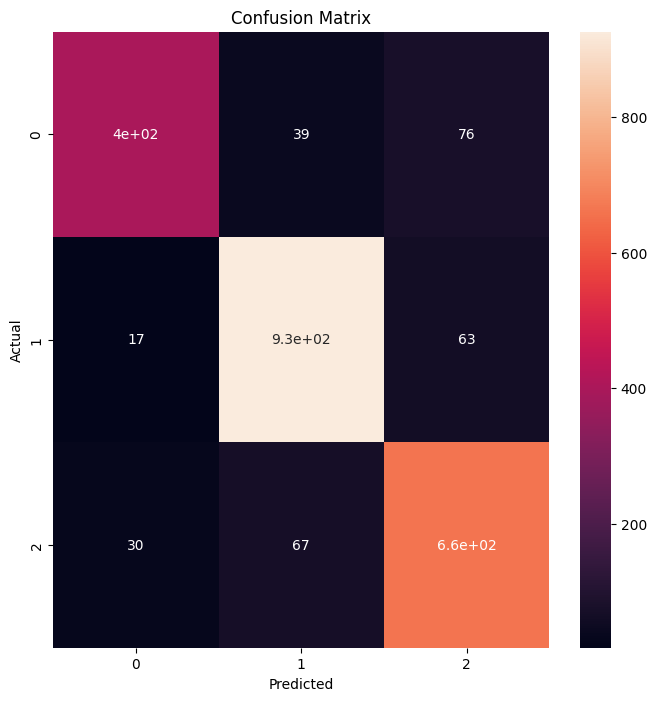

In [ ]:
cm = confusion_matrix(label , pred)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')